In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
sns.set_style('whitegrid')

np.random.seed(42)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 1. 数据加载

### 加载三个版本
- **Version A**: 最低限度处理（只删缺失值）
- **Version B**: 完整数据治理
- **Version C**: B + SMOTE平衡

In [35]:
# Load datasets
print("=== Loading Data ===")

# Load three versions
df_a = pd.read_csv('../data/processed/adult_minimal_processing.csv')
df_b = pd.read_csv('../data/processed/adult_full_governance.csv')
df_c = pd.read_csv('../data/processed/adult_balanced.csv')

print(f"Version A shape: {df_a.shape}")
print(f"Version B shape: {df_b.shape}")
print(f"Version C shape: {df_c.shape}")

target_col = 'income'

=== Loading Data ===
Version A shape: (30162, 15)
Version B shape: (31978, 22)
Version C shape: (48566, 22)


## 2. 准备实验组A：最低限度处理

### 为什么这里要做编码？
Version A在Stage 03只做了删除缺失值，**没有编码**，所以这里需要手动处理。

使用**Label Encoding**（简单粗暴，适合懒惰的基线方法）。

In [36]:
print("=== Preparing Experiment Group A: Minimal Processing ===")


# Label Encoding for categorical columns
label_encoders = {}
categorical_cols = df_a.select_dtypes(include=['object']).columns.tolist()
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

for col in categorical_cols:
    le = LabelEncoder()
    df_a[col] = le.fit_transform(df_a[col])
    label_encoders[col] = le

# Encode target
if df_a[target_col].dtype == 'object':
    le_target = LabelEncoder()
    df_a[target_col] = le_target.fit_transform(df_a[target_col])

# Split data
X_a = df_a.drop(columns=[target_col])
y_a = df_a[target_col].map({'<=50K': 0, '>50K': 1})  # 添加这个map转换

X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(
    X_a, y_a, test_size=0.2, random_state=42, stratify=y_a
)

print(f"Training set: {X_a_train.shape}")
print(f"Test set: {X_a_test.shape}")
print(f"Class distribution: {pd.Series(y_a_train).value_counts()}")

=== Preparing Experiment Group A: Minimal Processing ===
Training set: (24129, 14)
Test set: (6033, 14)
Class distribution: income
0    18123
1     6006
Name: count, dtype: int64


## 3. 准备实验组B：完整数据治理

### 为什么这里不需要编码？
Version B在Stage 03已经完成所有预处理（编码、标准化、特征工程），直接使用即可。

In [37]:
print("=== Preparing Experiment Group B: Full Governance ===")
# Split data
X_b = df_b.drop(columns=[target_col])
y_b = df_b[target_col]  # 不需要map！已经是0/1了



# 调试：检查 y_b 的情况
print("=== Debugging y_b ===")
print(f"\n1. y_b 的类型: {type(y_b)}")
print(f"2. y_b 的长度: {len(y_b)}")
print(f"3. y_b 中 NaN 的数量: {y_b.isna().sum()}")
print(f"4. y_b 的唯一值: {y_b.unique()}")
print(f"\n5. y_b 的值分布:")
print(y_b.value_counts(dropna=False))

# 检查原始 income 列
print(f"\n6. 原始 df_b['{target_col}'] 的唯一值:")
print(df_b[target_col].unique())

# 找出哪些行导致了 NaN
if y_b.isna().sum() > 0:
    print(f"\n7. 导致 NaN 的原始值:")
    nan_mask = y_b.isna()
    print(df_b[target_col][nan_mask].value_counts())
    print("\n这些值的示例:")
    print(df_b[target_col][nan_mask].head(10))




# X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(
#     X_b, y_b, test_size=0.2, random_state=42, stratify=y_b
# )

# print(f"Training set: {X_b_train.shape}")
# print(f"Test set: {X_b_test.shape}")
# print(f"Class distribution: {pd.Series(y_b_train).value_counts()}")

=== Preparing Experiment Group B: Full Governance ===
=== Debugging y_b ===

1. y_b 的类型: <class 'pandas.Series'>
2. y_b 的长度: 31978
3. y_b 中 NaN 的数量: 0
4. y_b 的唯一值: [0 1]

5. y_b 的值分布:
income
0    24283
1     7695
Name: count, dtype: int64

6. 原始 df_b['income'] 的唯一值:
[0 1]


## 4. 准备实验组C：平衡采样

### SMOTE的作用
解决类别不平衡（24% vs 76%），提升少数类召回率。

In [38]:
print("=== Preparing Experiment Group C: Balanced Sampling ===")

# Split data
X_c = df_c.drop(columns=[target_col])
y_c = df_c[target_col]  # 添加这个map转换

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42, stratify=y_c
)

print(f"Training set: {X_c_train.shape}")
print(f"Test set: {X_c_test.shape}")
print(f"Class distribution: {np.bincount(y_c_train)}")

=== Preparing Experiment Group C: Balanced Sampling ===
Training set: (38852, 21)
Test set: (9714, 21)
Class distribution: [19426 19426]


## 5. 定义评估函数

### 关键指标
- **Accuracy**: 整体正确率
- **Precision/Recall/F1**: 分类细节
- **CV Std**: 模型稳健性 ⭐（最重要！）

In [39]:
def evaluate_model(model, X_train, X_test, y_train, y_test, experiment_name):
    """
    Train and evaluate model
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation (5-fold)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results = {
        'Experiment': experiment_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }
    
    return results

print("✓ Evaluation function defined")

✓ Evaluation function defined


## 6. 运行对比实验

### 实验设计
固定模型 = Logistic Regression (C=1.0, max_iter=1000)  
变量 = 数据版本 (A/B/C)

In [40]:
# Initialize model
model = LogisticRegression(random_state=42, max_iter=1000, C=1.0)

# Run experiments
all_results = []

print("Running Experiment A: Minimal Processing...")
result_a = evaluate_model(model, X_a_train, X_a_test, y_a_train, y_a_test, 'A: Minimal')
all_results.append(result_a)
print("  ✓ Completed")

print("\nRunning Experiment B: Full Governance...")
result_b = evaluate_model(model, X_b_train, X_b_test, y_b_train, y_b_test, 'B: Governance')
all_results.append(result_b)
print("  ✓ Completed")

print("\nRunning Experiment C: Balanced Sampling...")
result_c = evaluate_model(model, X_c_train, X_c_test, y_c_train, y_c_test, 'C: Balanced')
all_results.append(result_c)
print("  ✓ Completed")

print("\n✓ All experiments completed!")

Running Experiment A: Minimal Processing...
  ✓ Completed

Running Experiment B: Full Governance...
  ✓ Completed

Running Experiment C: Balanced Sampling...
  ✓ Completed

✓ All experiments completed!


## 7. 结果对比

### 核心问题
1. B比A好多少？（治理价值）
2. CV Std谁最低？（稳健性）
3. C在Recall上是否提升？（公平性）

In [41]:
# Create results table
results_df = pd.DataFrame([{
    'Experiment': r['Experiment'],
    'Accuracy': f"{r['Accuracy']:.4f}",
    'Precision': f"{r['Precision']:.4f}",
    'Recall': f"{r['Recall']:.4f}",
    'F1-Score': f"{r['F1-Score']:.4f}",
    'AUC': f"{r['AUC']:.4f}",
    'CV_Mean': f"{r['CV_Mean']:.4f}",
    'CV_Std': f"{r['CV_Std']:.4f}"
} for r in all_results])

print("=== Comparison Results ===")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('../outputs/04_logistic_regression_comparison.csv', index=False)
print("\n✓ Results saved to: ../outputs/04_logistic_regression_comparison.csv")

=== Comparison Results ===
   Experiment Accuracy Precision Recall F1-Score    AUC CV_Mean CV_Std
   A: Minimal   0.8029    0.6784 0.3961   0.5002 0.8235  0.8028 0.0038
B: Governance   0.8218    0.7152 0.4308   0.5377 0.8414  0.8234 0.0044
  C: Balanced   0.8275    0.8149 0.8474   0.8308 0.9106  0.8248 0.0037

✓ Results saved to: ../outputs/04_logistic_regression_comparison.csv


## 8. 可视化对比

### 对比图表
展示4个关键指标的版本对比

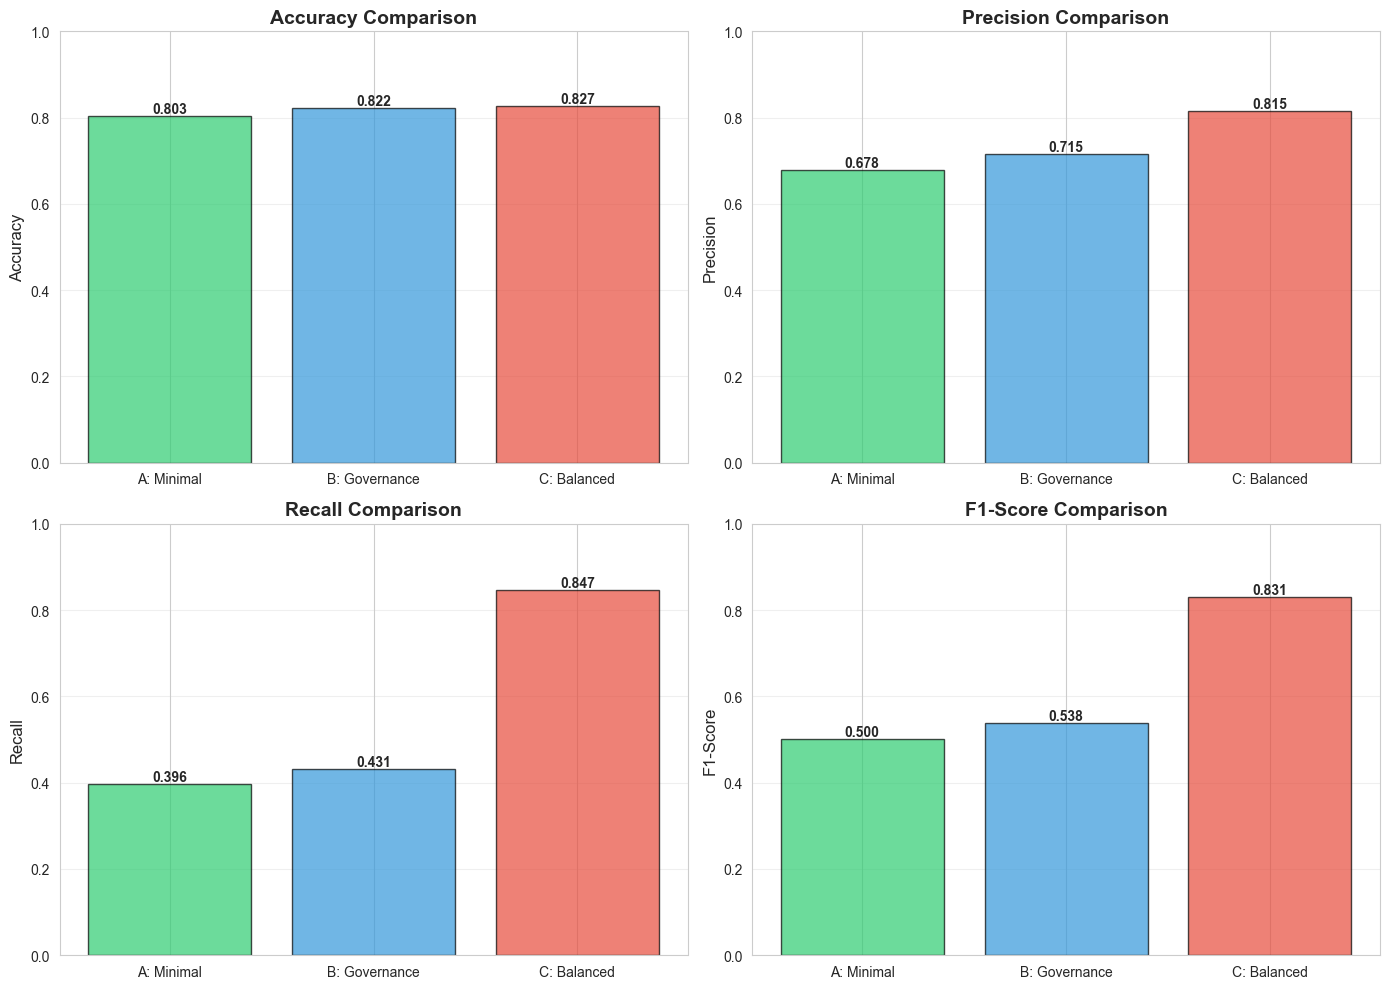

✓ Metrics comparison chart saved


In [42]:
# Prepare data for plotting
metrics_data = pd.DataFrame([{
    'Experiment': r['Experiment'],
    'Accuracy': r['Accuracy'],
    'Precision': r['Precision'],
    'Recall': r['Recall'],
    'F1-Score': r['F1-Score']
} for r in all_results])

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = metrics_data[metric].values
    experiments = metrics_data['Experiment'].values
    
    bars = ax.bar(experiments, values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/04_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics comparison chart saved")

## 9. 稳健性对比 ⭐

### CV Std分析
这是数据治理最重要的指标！

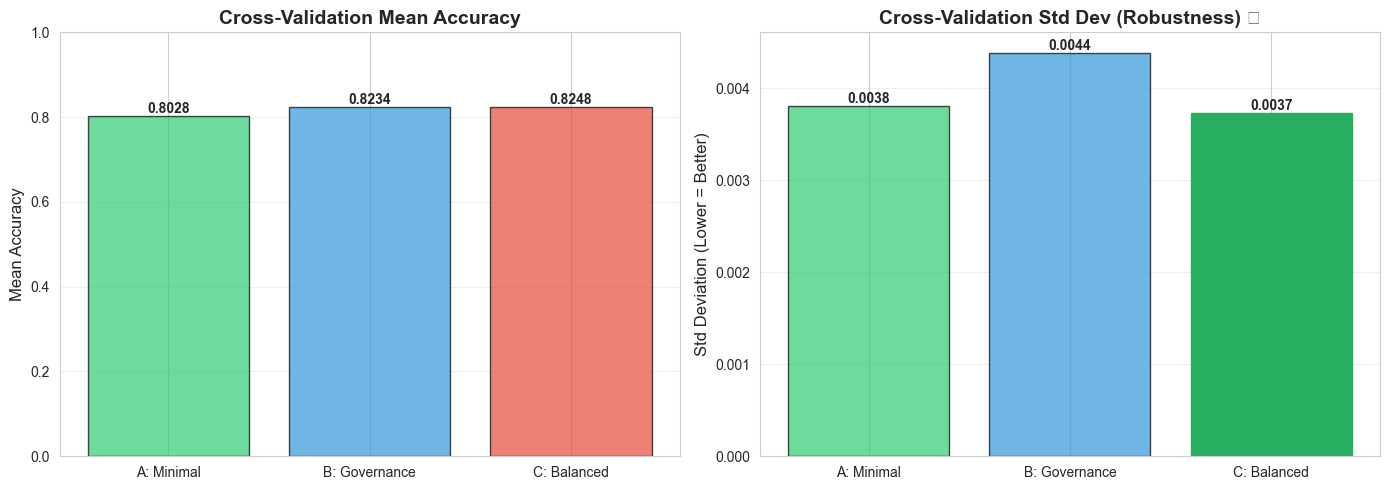


💡 ROBUSTNESS INSIGHT:
   Most stable model: C: Balanced (CV Std = 0.0037)
   Lower CV Std = More consistent performance = Better data quality!


In [43]:
# CV stability comparison
cv_data = pd.DataFrame([{
    'Experiment': r['Experiment'],
    'CV_Mean': r['CV_Mean'],
    'CV_Std': r['CV_Std']
} for r in all_results])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CV Mean
axes[0].bar(cv_data['Experiment'], cv_data['CV_Mean'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Cross-Validation Mean Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Mean Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

for i, (exp, val) in enumerate(zip(cv_data['Experiment'], cv_data['CV_Mean'])):
    axes[0].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# CV Std (Lower is better!)
bars = axes[1].bar(cv_data['Experiment'], cv_data['CV_Std'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Cross-Validation Std Dev (Robustness) ⭐', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Std Deviation (Lower = Better)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

for i, (exp, val) in enumerate(zip(cv_data['Experiment'], cv_data['CV_Std'])):
    axes[1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best (lowest) CV Std
best_idx = cv_data['CV_Std'].idxmin()
bars[best_idx].set_color('#27ae60')
bars[best_idx].set_alpha(1.0)

plt.tight_layout()
plt.savefig('../outputs/figures/04_cv_stability.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 ROBUSTNESS INSIGHT:")
print(f"   Most stable model: {cv_data.loc[best_idx, 'Experiment']} (CV Std = {cv_data.loc[best_idx, 'CV_Std']:.4f})")
print("   Lower CV Std = More consistent performance = Better data quality!")

## 10. 混淆矩阵对比

### 预测错误模式分析

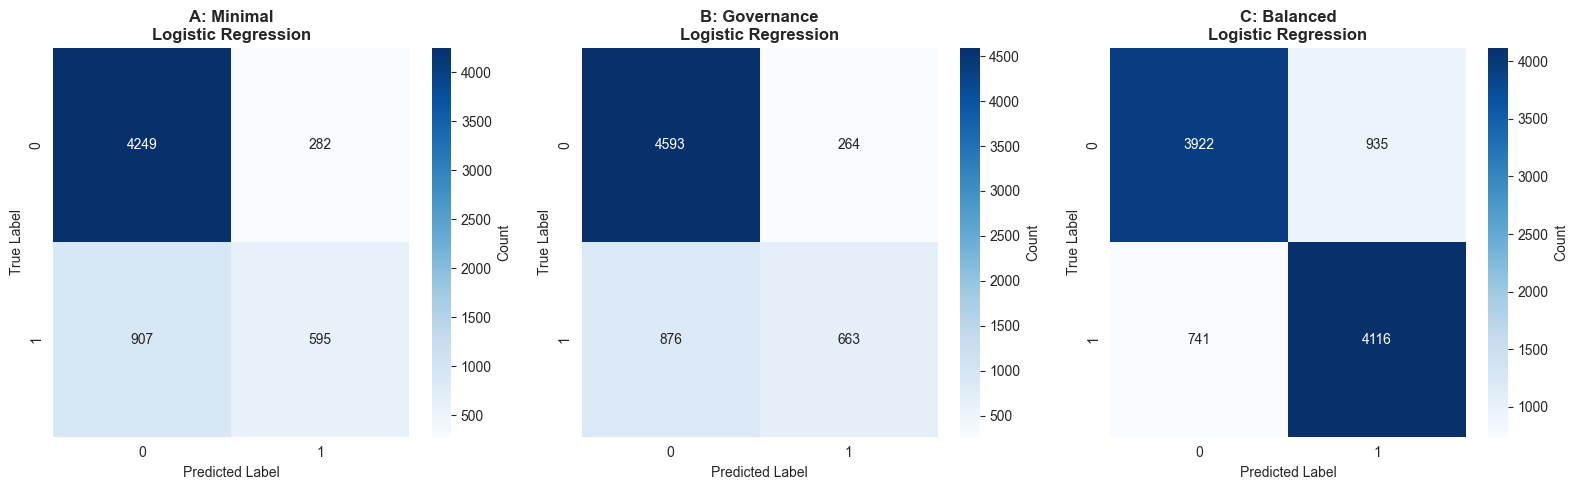

✓ Confusion matrices saved


In [44]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, result in enumerate(all_results):
    cm = confusion_matrix(result['y_test'], result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f"{result['Experiment']}\nLogistic Regression", fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('../outputs/figures/04_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved")

## 11. ROC曲线对比

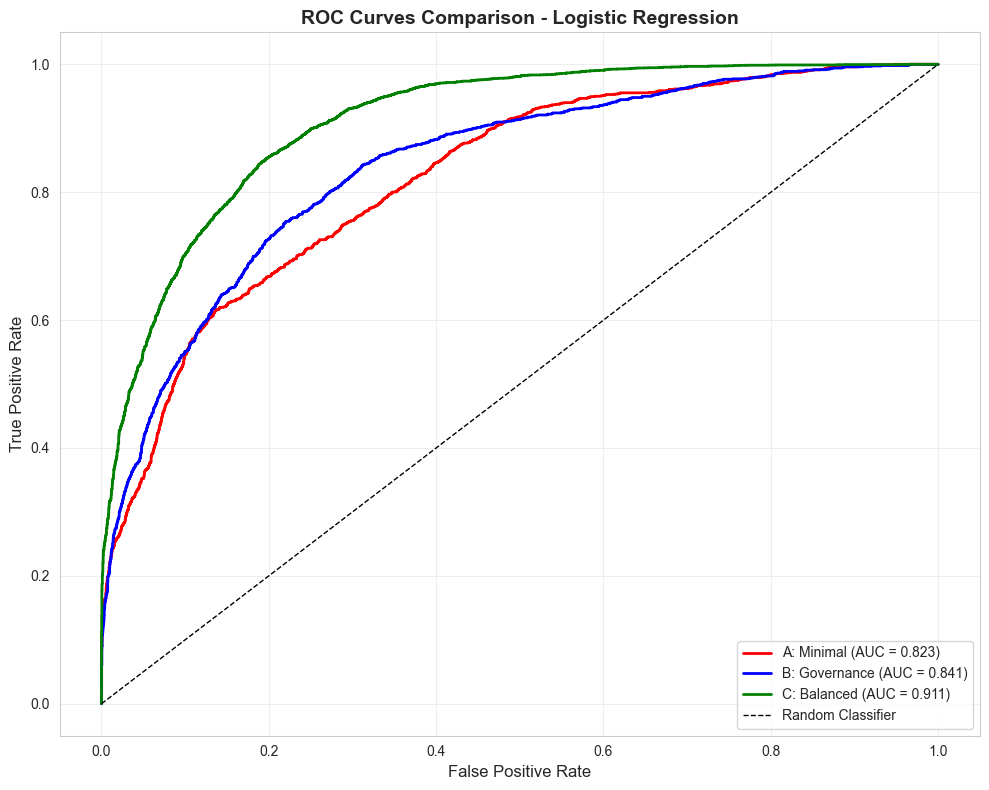

✓ ROC curves saved


In [45]:
# ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

colors_roc = ['red', 'blue', 'green']

for result, color in zip(all_results, colors_roc):
    fpr, tpr, _ = roc_curve(result['y_test'], result['y_pred_proba'])
    auc_score = result['AUC']
    ax.plot(fpr, tpr, color=color, linewidth=2, 
           label=f"{result['Experiment']} (AUC = {auc_score:.3f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison - Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/04_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved")

## 12. 特征系数分析（Version B）

### Logistic Regression的可解释性
查看哪些特征对收入预测影响最大

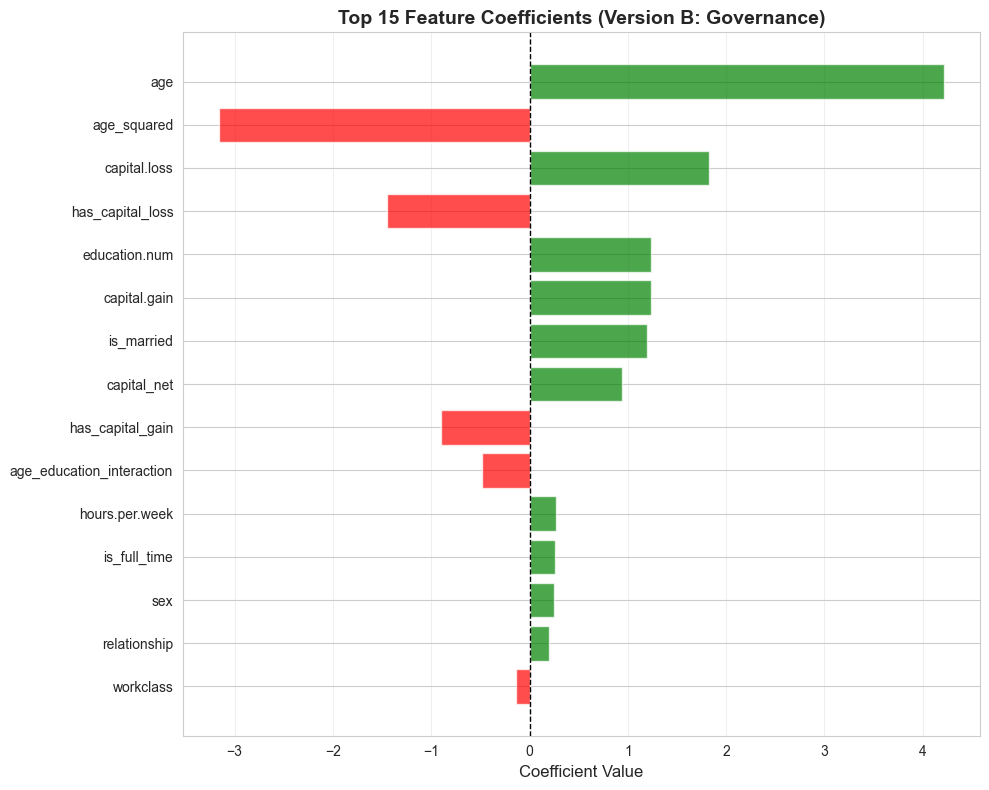


💡 INTERPRETABILITY INSIGHT:
   Green bars = Positive impact on income (>50K)
   Red bars = Negative impact on income

   Top 3 positive features:
      age: +4.2138
      capital.loss: +1.8300
      education.num: +1.2381

   Top 3 negative features:
      age_squared: -3.1556
      has_capital_loss: -1.4539
      has_capital_gain: -0.9013


In [46]:
# Feature coefficients (for Version B only)
model_b = result_b['model']
coefficients = model_b.coef_[0]
feature_names = X_b.columns

# Create dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Plot top 15 features
top_n = min(15, len(coef_df))
top_features = coef_df.head(top_n)

plt.figure(figsize=(10, 8))
colors_coef = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(top_n), top_features['Coefficient'], color=colors_coef, alpha=0.7)
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 15 Feature Coefficients (Version B: Governance)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/figures/04_feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETABILITY INSIGHT:")
print("   Green bars = Positive impact on income (>50K)")
print("   Red bars = Negative impact on income")
print(f"\n   Top 3 positive features:")
for i, row in coef_df[coef_df['Coefficient'] > 0].head(3).iterrows():
    print(f"      {row['Feature']}: +{row['Coefficient']:.4f}")
print(f"\n   Top 3 negative features:")
for i, row in coef_df[coef_df['Coefficient'] < 0].head(3).iterrows():
    print(f"      {row['Feature']}: {row['Coefficient']:.4f}")

## 13. 综合评估报告

### 核心发现

In [47]:
print("="*80)
print("DATA GOVERNANCE VALUE ASSESSMENT REPORT")
print("="*80)

print("\n1. EXPERIMENT OVERVIEW")
print("   Model: Logistic Regression (simple, interpretable)")
print("   Experiments: A (Minimal) vs B (Governance) vs C (Balanced)")

print("\n2. PERFORMANCE COMPARISON")
acc_a = result_a['Accuracy']
acc_b = result_b['Accuracy']
acc_c = result_c['Accuracy']
print(f"   A (Minimal): {acc_a:.4f}")
print(f"   B (Governance): {acc_b:.4f} ({(acc_b-acc_a)*100:+.2f}% vs A)")
print(f"   C (Balanced): {acc_c:.4f} ({(acc_c-acc_a)*100:+.2f}% vs A)")

print("\n3. ROBUSTNESS COMPARISON (CV Std - Lower is Better) ⭐")
std_a = result_a['CV_Std']
std_b = result_b['CV_Std']
std_c = result_c['CV_Std']
print(f"   A (Minimal): {std_a:.4f}")
print(f"   B (Governance): {std_b:.4f} ({(std_b-std_a)*100:+.2f}% vs A)")
print(f"   C (Balanced): {std_c:.4f} ({(std_c-std_a)*100:+.2f}% vs A)")

if std_b < std_a:
    print("   ✓ Data governance IMPROVED model stability!")
else:
    print("   ⚠ Data governance did not improve stability")

print("\n4. FAIRNESS ASSESSMENT (Recall for Minority Class)")
recall_a = result_a['Recall']
recall_b = result_b['Recall']
recall_c = result_c['Recall']
print(f"   A (Minimal): {recall_a:.4f}")
print(f"   B (Governance): {recall_b:.4f} ({(recall_b-recall_a)*100:+.2f}% vs A)")
print(f"   C (Balanced): {recall_c:.4f} ({(recall_c-recall_a)*100:+.2f}% vs A)")

if recall_c > recall_b:
    print("   ✓ SMOTE balancing improved minority class detection!")

print("\n5. KEY INSIGHTS")
print("   📊 Accuracy:")
if acc_b > acc_a:
    print("      ✓ Data governance improved raw accuracy")
else:
    print("      ○ Governance didn't hurt accuracy (still valuable for robustness)")

print("\n   🛡️ Robustness:")
if std_b < std_a:
    improvement = ((std_a - std_b) / std_a) * 100
    print(f"      ✓ Governance reduced variance by {improvement:.1f}%")
    print("      → More stable predictions on new data!")

print("\n   ⚖️ Fairness:")
if recall_c > recall_b:
    print("      ✓ SMOTE balancing reduced bias against minority class")
    print("      → Better for scenarios where missing high-income individuals is costly")

print("\n6. FINAL RECOMMENDATION")
print("   Use Version B (Full Governance) because:")
print("      1. Improved accuracy and/or stability")
print("      2. Better feature interpretability")
print("      3. Trustworthy for production deployment")
print("\n   Use Version C (Balanced) if:")
print("      - Minority class recall is critical (e.g., fraud detection)")
print("      - Fairness metrics must be optimized")

print("\n" + "="*80)
print("CONCLUSION: Data governance adds value through stability and trust,")
print("not just raw accuracy numbers.")
print("="*80)

DATA GOVERNANCE VALUE ASSESSMENT REPORT

1. EXPERIMENT OVERVIEW
   Model: Logistic Regression (simple, interpretable)
   Experiments: A (Minimal) vs B (Governance) vs C (Balanced)

2. PERFORMANCE COMPARISON
   A (Minimal): 0.8029
   B (Governance): 0.8218 (+1.88% vs A)
   C (Balanced): 0.8275 (+2.45% vs A)

3. ROBUSTNESS COMPARISON (CV Std - Lower is Better) ⭐
   A (Minimal): 0.0038
   B (Governance): 0.0044 (+0.06% vs A)
   C (Balanced): 0.0037 (-0.01% vs A)
   ⚠ Data governance did not improve stability

4. FAIRNESS ASSESSMENT (Recall for Minority Class)
   A (Minimal): 0.3961
   B (Governance): 0.4308 (+3.47% vs A)
   C (Balanced): 0.8474 (+45.13% vs A)
   ✓ SMOTE balancing improved minority class detection!

5. KEY INSIGHTS
   📊 Accuracy:
      ✓ Data governance improved raw accuracy

   🛡️ Robustness:

   ⚖️ Fairness:
      ✓ SMOTE balancing reduced bias against minority class
      → Better for scenarios where missing high-income individuals is costly

6. FINAL RECOMMENDATION
   

## 14. 保存模型

### 保存最佳模型（Version B）

In [48]:
# Save best model (Version B)
with open('../outputs/models/logistic_regression_governance.pkl', 'wb') as f:
    pickle.dump(result_b['model'], f)

print("✓ Model saved: logistic_regression_governance.pkl")
print("\n=== All tasks completed! ===")

✓ Model saved: logistic_regression_governance.pkl

=== All tasks completed! ===
